In [1]:
import warnings
import random
import pandas as pd
import numpy as np
import ipywidgets as widgets
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from numba import njit
from typing import Literal
from collections.abc import Callable
from scipy.optimize._optimize import OptimizeResult
from tqdm.notebook import tqdm
from IPython.display import display
from scipy.optimize import differential_evolution

plt.style.use("default")

In [2]:
# Simulation with Random Walk


@njit
def combine_behavior_jit(
    e_cells: np.ndarray, t_cells: np.ndarray, r: float, k_on: float, rng_vals: np.ndarray
) -> (np.ndarray, np.ndarray, np.ndarray, int, int):
    max_e: int = e_cells.shape[0]
    max_t: int = t_cells.shape[0]
    r2: float = (2 * r) ** 2

    touched_count = 0
    combined_count = 0

    remaining_e: np.ndarray = np.empty_like(e_cells)
    new_c: np.ndarray = np.empty((max_e, 2))
    e_idx = 0
    c_idx = 0

    taken_t: np.ndarray = np.zeros(max_t, dtype=np.uint8)

    for i in range(max_e):
        ex, ey = e_cells[i]
        found = False

        for j in range(max_t):
            if taken_t[j] == 1:
                continue
            tx, ty = t_cells[j]
            dx = ex - tx
            dy = ey - ty
            dist2 = dx * dx + dy * dy

            if dist2 <= r2:
                touched_count += 1
                if rng_vals[i] < k_on:
                    new_c[c_idx, 0] = (ex + tx) / 2
                    new_c[c_idx, 1] = (ey + ty) / 2
                    c_idx += 1
                    taken_t[j] = 1
                    combined_count += 1
                    found = True
                    break

        if not found:
            remaining_e[e_idx] = e_cells[i]
            e_idx += 1

    remaining_e = remaining_e[:e_idx]
    new_c = new_c[:c_idx]
    kept_t: np.ndarray = t_cells[taken_t == 0]

    return remaining_e, kept_t, new_c, touched_count, combined_count


class SquareWell:
    def __init__(self, size: float, mode: Literal["reflect", "wrap"] = "reflect") -> None:
        """
        mode: "reflect" or "wrap"
            - "reflect" means the boundary is 'walling',
                the point stays at the boundary if it goes beyond the boundary
            - "wrap" means the boundary is 'wrapping',
                the point wraps around to the other side of the boundary, like a planar model of a torus
        """
        self.L: float = size
        self.mode: Literal["reflect", "wrap"] = mode

    def random_position(self) -> tuple[np.float64, np.float64]:
        # Return a random (x, y) point within the square, only used during initialization
        return tuple(np.random.uniform(0, self.L, size=2))

    def apply_boundary_batch(self, coords: np.ndarray) -> np.ndarray:
        if self.mode == "reflect":
            return np.clip(coords, 0, self.L)
        else:
            return coords % self.L


class WellSimulation:
    def __init__(
        self,
        E_0: int,
        T_0: int,
        r: float,
        m: float,
        N: int,
        L: float,
        k_on: float,
        k_off: float,
        k_kill: float,
        g_E: float,
        g_T: float,
        early_stop: tuple[bool, int, float],
        log_all: bool = False,
        use_tqdm: bool = True,
        seed: int | None = None,
    ) -> None:
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        if E_0 == 0 and T_0 == 0:
            raise ValueError("Initializing both E and T cell to be 0 is not allowed.")

        self.E_0: int = E_0
        self.T_0: int = T_0
        self.r: float = r
        self.m: float = m
        self.N: int = N
        self.L: float = L
        self.k_on: float = k_on
        self.k_off: float = k_off
        self.k_kill: float = k_kill
        self.g_E: float = g_E
        self.g_T: float = g_T
        self.early_stop: tuple[bool, int, float] = early_stop
        self.log_all: bool = log_all
        self.use_tqdm: bool = use_tqdm

        self.simulated = False

        # Well
        self.well = SquareWell(L, mode="reflect")

        # Initialize cells as (N, 2) arrays
        self.e_cells: np.ndarray = self._initialize_cells(E_0)
        self.t_cells: np.ndarray = self._initialize_cells(T_0)
        self.existing_c_cells: np.ndarray = np.empty((0, 2))
        self.new_c_cells: np.ndarray = np.empty((0, 2))

        # History
        self.history: dict[str, list] = {"E": [], "T": [], "C": []}
        if log_all:
            self.full_history: list[dict] = []
            self.step_stats: list[dict[str, int]] = []

        # Initial logging
        self._log()

    def _initialize_cells(self, count: int) -> np.ndarray:
        # Initialize `count` random positions in the well as an (N, 2) NumPy array.
        return np.random.uniform(0, self.L, size=(count, 2))

    def _combine_behavior(self) -> None:
        if self.e_cells.shape[0] == 0 or self.t_cells.shape[0] == 0:
            if self.log_all:
                self.step_stats.append({"touched": 0, "combined": 0, "split": 0, "killed": 0})
            return

        rng_vals: np.ndarray = np.random.rand(self.e_cells.shape[0])
        self.e_cells, self.t_cells, self.new_c_cells, touched, combined = combine_behavior_jit(
            self.e_cells, self.t_cells, self.r, self.k_on, rng_vals
        )
        if self.log_all:
            self.step_stats.append({"touched": touched, "combined": combined, "split": 0, "killed": 0})

    def _c_cell_behavior(self) -> None:
        n_c: int = self.existing_c_cells.shape[0]
        if n_c == 0:
            if self.log_all:
                if len(self.step_stats) < len(self.history["E"]):
                    self.step_stats.append({"touched": 0, "combined": 0, "split": 0, "killed": 0})
            return

        rnd: np.ndarray = np.random.rand(n_c)
        is_split = rnd < self.k_off
        is_kill = (rnd >= self.k_off) & (rnd < self.k_off + self.k_kill)
        is_stay = ~(is_split | is_kill)

        # Split: create E and T from the same location
        split_coords: np.ndarray = self.existing_c_cells[is_split]
        self.e_cells = np.vstack([self.e_cells, split_coords]) if split_coords.size > 0 else self.e_cells
        self.t_cells = np.vstack([self.t_cells, split_coords]) if split_coords.size > 0 else self.t_cells

        # Kill: create E only
        kill_coords: np.ndarray = self.existing_c_cells[is_kill]
        self.e_cells = np.vstack([self.e_cells, kill_coords]) if kill_coords.size > 0 else self.e_cells

        # Keep the rest
        self.existing_c_cells = self.existing_c_cells[is_stay]

        # Log stats
        if self.log_all:
            if len(self.step_stats) < len(self.history["E"]):
                self.step_stats.append({"touched": 0, "combined": 0, "split": np.count_nonzero(is_split), "killed": np.count_nonzero(is_kill)})
            else:
                self.step_stats[-1]["split"] += np.count_nonzero(is_split)
                self.step_stats[-1]["killed"] += np.count_nonzero(is_kill)

    def _cell_move(self) -> None:
        if self.e_cells.shape[0] == 0:
            return

        # Generate 2D Gaussian noise for all E-cells
        noise: np.ndarray = np.random.normal(0, self.m, size=self.e_cells.shape)

        # Apply movement and boundary conditions
        moved_coords: np.ndarray = self.e_cells + noise
        self.e_cells = self.well.apply_boundary_batch(moved_coords)

    def _cell_grow(self) -> None:
        # --- E cell growth ---
        n_E: int = self.e_cells.shape[0]
        if n_E > 0:
            grow_mask_E = np.random.rand(n_E) < self.g_E
            parent_E: np.ndarray = self.e_cells[grow_mask_E]
            displacements_E: np.ndarray = np.random.uniform(-self.r, self.r, size=parent_E.shape)
            new_E: np.ndarray = self.well.apply_boundary_batch(parent_E + displacements_E)
            self.e_cells = np.vstack([self.e_cells, new_E])

        # --- T cell growth ---
        n_T: int = self.t_cells.shape[0]
        if n_T > 0:
            grow_mask_T = np.random.rand(n_T) < self.g_T
            parent_T: np.ndarray = self.t_cells[grow_mask_T]
            displacements_T: np.ndarray = np.random.uniform(-self.r, self.r, size=parent_T.shape)
            new_T: np.ndarray = self.well.apply_boundary_batch(parent_T + displacements_T)
            self.t_cells = np.vstack([self.t_cells, new_T])

    def _log(self) -> None:
        # Record counts
        self.history["E"].append(self.e_cells.shape[0])
        self.history["T"].append(self.t_cells.shape[0])
        self.history["C"].append(self.existing_c_cells.shape[0] + self.new_c_cells.shape[0])

        if self.log_all:
            frame: dict = {
                "E": self.e_cells.copy(),
                "T": self.t_cells.copy(),
                "C": np.vstack([self.existing_c_cells, self.new_c_cells]) if self.new_c_cells.size > 0 else self.existing_c_cells.copy(),
            }
            self.full_history.append(frame)

        # Merge in new C-cells for the next step
        if self.new_c_cells.size > 0:
            self.existing_c_cells = np.vstack([self.existing_c_cells, self.new_c_cells]) if self.existing_c_cells.size > 0 else self.new_c_cells
        self.new_c_cells = np.empty((0, 2))

    def _step(self) -> None:
        """
        Perform one simulation step and log:

        - Move E-cells
        - Handle E–T binding
        - Resolve C-cell actions (split, kill, stay)
        - Grow E and T cells
        """

        self._cell_move()
        self._combine_behavior()
        self._c_cell_behavior()
        self._cell_grow()
        self._log()

    def run(self) -> None:
        # Fast path: if no E-cells, nothing happens
        if self.E_0 == 0:
            self.history["E"] = [0] * (self.N + 1)
            self.history["C"] = [0] * (self.N + 1)
            self.history["T"] = [round(self.T_0 * (1 + self.g_T) ** t) for t in range(self.N + 1)]
            self.simulated = True
            return

        unchanged_count = 0
        prev_T: int = self.history["T"][-1]

        iterator: tqdm | range = tqdm(range(self.N), desc="Simulating") if self.use_tqdm else range(self.N)

        for _ in iterator:
            self._step()

            curr_E: int = self.history["E"][-1]
            curr_T: int = self.history["T"][-1]
            curr_C: int = self.history["C"][-1]

            if self.early_stop[0]:
                # Track T stability
                if prev_T * (1 - self.early_stop[2]) <= curr_T <= prev_T * (1 + self.early_stop[2]):
                    unchanged_count += 1
                else:
                    unchanged_count = 0
                prev_T = curr_T

                if curr_T == 0 and curr_C == 0:
                    # print("Stopping: all T-cells eliminated.")
                    break
                if curr_E == 0 and curr_C == 0:
                    # print("Stopping: all E-cells eliminated.")
                    break
                if unchanged_count >= 100:
                    # print(f"Stopping: T unchanged for 100 steps.")
                    break
                if curr_E + curr_C > 0 and curr_T / (curr_E + curr_C) >= self.early_stop[1]:
                    # print("Stopping: T has grown uncontrollable.")
                    break

        self.simulated = True

    def plot_history(self) -> None:
        """
        Plot population dynamics over time in a 2×2 layout.

        - Top-left: T-cell and C-cell counts
        - Top-right: E-cell count
        - Bottom-left: F(t) = T(t) / T_baseline(t)
        - Bottom-right: G(t) = T / (E + C)
        """
        if not self.simulated:
            warnings.warn("No simulation has been run yet. Run the run() method first.", UserWarning)
            return

        T: np.ndarray = np.array(self.history["T"])
        E: np.ndarray = np.array(self.history["E"])
        C: np.ndarray = np.array(self.history["C"])

        baseline = WellSimulation(
            E_0=0,
            T_0=self.T_0,
            r=self.r,
            m=self.m,
            N=self.N,
            L=self.L,
            k_on=self.k_on,
            k_off=self.k_off,
            k_kill=self.k_kill,
            g_E=self.g_E,
            g_T=self.g_T,
            early_stop=(False, 0, 0.0),
            log_all=False,
            use_tqdm=False,
        )
        baseline.run()
        baseline_T: list[int] = baseline.history["T"]

        time_steps: np.ndarray = np.arange(len(T))
        min_len: int = min(len(T), len(baseline_T))
        baseline_T_array: np.ndarray = np.array(baseline_T[:min_len])
        T_crop: np.ndarray = T[:min_len]

        # Avoid division by zero
        F: np.ndarray = np.where(baseline_T_array > 0, T_crop / baseline_T_array, 0.0)
        G: np.ndarray = np.where((E + C) > 0, T / (E + C), 0.0)

        fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)

        stop_step: int = len(T) - 1
        stopped_early: bool = len(T) < self.N + 1

        # --- T and C ---
        axes[0, 0].plot(time_steps, T, label="T-cells", color="red")
        axes[0, 0].plot(time_steps, C, label="C-cells", color="green")
        axes[0, 0].set_ylabel("T / C Count")
        axes[0, 0].set_title("T and C Cells")
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # --- E ---
        axes[0, 1].plot(time_steps, E, label="E-cells", color="blue")
        axes[0, 1].set_ylabel("E Count")
        axes[0, 1].set_title("E Cells")
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # --- F ---
        axes[1, 0].plot(np.arange(len(F)), F, label="F(t)", color="purple")
        axes[1, 0].set_xlabel("Time Step")
        axes[1, 0].set_ylabel("F(t)")
        axes[1, 0].set_title("Normalized T-Cell Count")
        axes[1, 0].legend()
        axes[1, 0].grid(True)
        axes[1, 0].set_ylim(0, max(1.1, np.max(F) * 1.1))

        # --- G ---
        axes[1, 1].plot(time_steps, G, label="G = T / (E + C)", color="orange")
        axes[1, 1].set_xlabel("Time Step")
        axes[1, 1].set_ylabel("G(t)")
        axes[1, 1].set_title("T-to-E Ratio")
        axes[1, 1].legend()
        axes[1, 1].grid(True)
        axes[1, 1].set_ylim(0, max((self.T_0 / max(1, self.E_0)) * 1.1, np.max(G) * 1.1))

        if stopped_early:
            for ax in axes.flatten():
                ax.axvline(stop_step, color="gray", linestyle="--", alpha=0.7)

        for ax in axes[1]:
            ax.set_xlim(0, self.N)

        plt.tight_layout()
        plt.show()

    def plot_snapshot(self, figsize: int = 6) -> None:
        """
        Display an interactive slider to visualize snapshots of cell positions at different time steps.
        Requires `log_all=True` to be set when initializing.
        """
        if self.E_0 == 0:
            warnings.warn("This is a baseline simulation, no snapshot info is recorded.", UserWarning)
            return
        if not self.simulated:
            warnings.warn("No simulation has been run yet. Run the run() method first.", UserWarning)
            return
        if self.full_history is None or len(self.full_history) == 0:
            print("No full history to explore. Set log_all=True when initializing.")
            return

        slider = widgets.IntSlider(
            value=0,
            min=0,
            max=len(self.full_history) - 1,
            step=1,
            description="Time step:",
            continuous_update=False,
        )
        button_prev = widgets.Button(description="−", layout=widgets.Layout(width="40px"))
        button_next = widgets.Button(description="+", layout=widgets.Layout(width="40px"))
        figsize_widget = widgets.IntSlider(value=figsize, min=4, max=10)

        def decrease(_) -> None:
            if slider.value > slider.min:
                slider.value -= 1

        def increase(_) -> None:
            if slider.value < slider.max:
                slider.value += 1

        button_prev.on_click(decrease)
        button_next.on_click(increase)

        controls = widgets.HBox([button_prev, slider, button_next])

        def _plot_snapshot_at_time(t: int, figsize: int = 6) -> None:
            frame: dict = self.full_history[t]
            fig, ax = plt.subplots(figsize=(figsize, figsize))
            ax.set_xlim(0, self.L)
            ax.set_ylim(0, self.L)
            ax.set_title(f"Cell Positions at t = {t}")

            r_marker_size: float = (self.r / (self.L / figsize)) * 72
            marker_area: float = r_marker_size**2

            for key, color, label, marker, alpha, size_mult in [
                ("E", "blue", "E", "o", 0.5, 1.0),
                ("T", "red", "T", "o", 0.5, 1.0),
                ("C", "green", "C", "D", 0.75, 2.0),
            ]:
                if len(frame[key]) > 0:
                    coords: np.ndarray = np.array(frame[key])
                    ax.scatter(
                        coords[:, 0],
                        coords[:, 1],
                        color=color,
                        label=label,
                        alpha=alpha,
                        marker=marker,
                        s=marker_area * size_mult,
                    )

            ax.legend(loc="upper right")
            ax.grid(True)
            plt.show()

        out = widgets.interactive_output(
            _plot_snapshot_at_time,
            {"t": slider, "figsize": figsize_widget},
        )

        display(controls, out)


# Single Scenario MC


def single_scenario_monte_carlo(n_runs: int, sim_kwargs: dict, seed_offset: int = 0, use_tqdm: bool = True) -> (dict[str, np.ndarray], np.ndarray):
    simulation: dict = {"E": [], "T": [], "C": []}
    target_len: int = sim_kwargs["N"] + 1  # expected time steps per run

    iterator: tqdm | range = tqdm(range(n_runs), desc="Simulating (E>0)") if use_tqdm else range(n_runs)
    for i in iterator:
        sim = WellSimulation(**sim_kwargs, log_all=False, use_tqdm=False, seed=seed_offset + i)
        sim.run()

        for k in ["E", "T", "C"]:
            history: list = sim.history[k]
            if len(history) < target_len:
                pad_value: int = history[-1]
                history = history + [pad_value] * (target_len - len(history))
            simulation[k].append(history)

    for k in ["E", "T", "C"]:
        simulation[k] = np.array(simulation[k])

    # Run a single E=0 baseline (no padding needed)
    baseline_kwargs: dict = sim_kwargs.copy()
    baseline_kwargs["E_0"] = 0
    baseline_kwargs["early_stop"] = (False, 0, 0.0)
    baseline = WellSimulation(**baseline_kwargs, log_all=False, use_tqdm=False, seed=99999)
    baseline.run()
    T_baseline: np.ndarray = np.array(baseline.history["T"])

    # Compute F = T(t, E>0) / T(t, E=0)
    with np.errstate(divide="ignore", invalid="ignore"):
        simulation["F"] = simulation["T"] / T_baseline

    return simulation, T_baseline


def plot_result_trend(results: dict[str, np.ndarray], use_median: bool = False) -> None:
    """
    Plot E(t), T(t), C(t), and F(t) = T(t; E>0) / T(t; E=0) over time
    with average (mean or median) +/- std and summary of final values.
    """
    average_func: Callable = np.nanmedian if use_median else np.nanmean
    time: np.ndarray = np.arange(results["E"].shape[1])
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

    def summarize(values: np.ndarray) -> str:
        final: np.ndarray = values[:, -1]
        return f"(final: {average_func(final):.4f} ± {np.nanstd(final):.4f})"

    def plot_panel(ax, key: str, color: str, label: str):
        avg: np.ndarray = average_func(results[key], axis=0)
        std: np.ndarray = np.nanstd(results[key], axis=0)
        ax.plot(time, avg, color=color, label=label)
        ax.fill_between(time, avg - std, avg + std, color=color, alpha=0.3, label="±1 SD")
        ax.set_title(f"{label} {summarize(results[key])}")
        ax.grid(True)
        ax.legend()

    plot_panel(axes[0, 0], "E", "blue", "E-cells")
    plot_panel(axes[0, 1], "T", "red", "T-cells")
    plot_panel(axes[1, 0], "C", "green", "C-cells")
    plot_panel(axes[1, 1], "F", "purple", "F = T(t; E>0) / T(t; E=0)")

    for ax in axes[1]:
        ax.set_xlabel("Time step")

    plt.tight_layout()
    plt.show()


def plot_result_distribution(results: dict[str, np.ndarray], step: int = 20, use_violin: bool = False, use_logscale: bool = False) -> None:
    # Plot distribution (box or violin) of E, T, C, and F over time in a 2×2 layout.
    max_t: int = results["E"].shape[1]
    time_points: np.ndarray = np.unique(np.concatenate(([1], np.arange(step, max_t, step), [max_t - 1])))

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

    def plot_panel(ax, key: str, color: str, title: str) -> None:
        raw_data: list[np.ndarray] = [results[key][:, t] for t in time_points]
        if use_logscale:
            all_non_zero: np.ndarray = np.concatenate([d[d > 0] for d in raw_data if np.any(d > 0)])
            smallest_non_zero_value: float = np.min(all_non_zero) if len(all_non_zero) > 0 else 1e-4
            replacement_value: float = smallest_non_zero_value / 10
            print(f"=== Log scale active: replacing {key} values ≤ 0 with {replacement_value:.1e} ===")
            data: list[np.ndarray] = [np.where(d <= 0, replacement_value, d) for d in raw_data]
        else:
            data = raw_data

        if use_violin:
            parts = ax.violinplot(data, positions=time_points, widths=step * 0.6)
            for pc in parts["bodies"]:
                pc.set_facecolor(color)
                pc.set_alpha(0.5)
        else:
            ax.boxplot(
                data,
                positions=time_points,
                widths=step * 0.6,
                patch_artist=True,
                boxprops=dict(facecolor=color, alpha=0.4),
                medianprops=dict(color="black", linewidth=2),
            )

        ax.set_title(title)
        if use_logscale:
            ax.set_yscale("log")
        ax.grid(True)

    plot_panel(axes[0, 0], "E", "blue", "E-cell Distribution")
    plot_panel(axes[0, 1], "T", "red", "T-cell Distribution")
    plot_panel(axes[1, 0], "C", "green", "C-cell Distribution")
    plot_panel(axes[1, 1], "F", "purple", "F = T(t; E>0) / T(t; E=0)")

    for ax in axes[1]:
        ax.set_xlabel("Time step")

    plt.tight_layout()
    plt.show()


# Grid MC


def grid_scenario_monte_carlo(E0_range: np.ndarray, T0_range: np.ndarray, base_kwargs: dict, n_runs: int = 100, seed_offset: int = 0) -> np.ndarray:
    # Run Monte Carlo for F = T(t; E>0) / T(t; E=0) over grid of E_0 and T_0.
    shape: tuple[int, int, int] = (len(E0_range), len(T0_range), n_runs)
    grid_F: np.ndarray = np.full(shape, np.nan)

    iterator: tqdm = tqdm([(i, j) for i in range(len(E0_range)) for j in range(len(T0_range))], desc="Grid Monte Carlo")

    for i, j in iterator:
        E_0: int = E0_range[i]  # pyright: ignore[reportAssignmentType]
        T_0: int = T0_range[j]  # pyright: ignore[reportAssignmentType]

        # Sim with E > 0
        kwargs: dict = base_kwargs.copy()
        kwargs.update({"E_0": E_0, "T_0": T_0})
        sim_result: dict[str, np.ndarray]
        T_baseline: np.ndarray
        sim_result, T_baseline = single_scenario_monte_carlo(
            n_runs=n_runs,
            sim_kwargs=kwargs,
            seed_offset=seed_offset,
            use_tqdm=False,
        )

        T_E_final: np.ndarray = sim_result["T"][:, -1]
        T_0_final: int = T_baseline[-1]

        F_final: np.ndarray = T_E_final / T_0_final
        grid_F[i, j, :] = F_final

    return grid_F


def plot_F_surface_interactive(grid_F: np.ndarray, E0_range: np.ndarray, T0_range: np.ndarray, use_median: bool = False) -> None:
    # Interactive Plotly version of F(t) surface/heatmap across (E_0, T_0), aggregated by mean or median.
    stat_func: Callable = np.nanmedian if use_median else np.nanmean
    Z: np.ndarray = stat_func(grid_F, axis=2)
    E0_vals: np.ndarray = np.array(list(E0_range))
    T0_vals: np.ndarray = np.array(list(T0_range))
    fig = go.Figure(data=[go.Surface(z=Z, x=T0_vals, y=E0_vals, colorscale="Viridis", colorbar=dict(title="F(t)"))])
    fig.update_layout(title=f"F(t) Across (E_0, T_0)", scene=dict(xaxis_title="T_0", yaxis_title="E_0", zaxis_title="F(t)"), width=900, height=700)
    fig.show()


# Optimizer


def build_optimizer_components(param_spec: dict, obs_E, obs_T, obs_C, n_runs=30) -> (Callable, list[tuple], list[str], dict):
    variable_names: list[str] = []
    bounds: list[tuple] = []
    known_variables: dict = {}

    for key, val in param_spec.items():
        if isinstance(val, tuple) and key != "early_stop":
            variable_names.append(key)
            bounds.append(val)
        else:
            known_variables[key] = val

    def objective(theta: np.ndarray) -> np.float64:
        param_values: dict = dict(zip(variable_names, theta))
        sim_kwargs: dict = {**known_variables, **param_values}

        sim_dict, _ = single_scenario_monte_carlo(n_runs=n_runs, sim_kwargs=sim_kwargs, use_tqdm=False)

        sim_E: np.ndarray = np.median(sim_dict["E"], axis=0)
        sim_T: np.ndarray = np.median(sim_dict["T"], axis=0)
        sim_C: np.ndarray = np.median(sim_dict["C"], axis=0)

        loss: np.float64 = np.mean((sim_E - obs_E) ** 2 + (sim_T - obs_T) ** 2 + (sim_C - obs_C) ** 2)

        return loss

    return objective, bounds, variable_names, known_variables


def fit_params(param_spec: dict, obs_E, obs_T, obs_C, n_runs=30) -> dict:
    loss_fn, bounds, var_names, known_vars = build_optimizer_components(param_spec, obs_E, obs_T, obs_C, n_runs)
    result: OptimizeResult = differential_evolution(
        func=loss_fn, bounds=bounds, strategy="best1bin", workers=1, updating="deferred", maxiter=20, disp=False
    )

    theta_best = result.x
    fitted_params: dict = dict(zip(var_names, theta_best))
    return {**known_vars, **fitted_params}

Output()

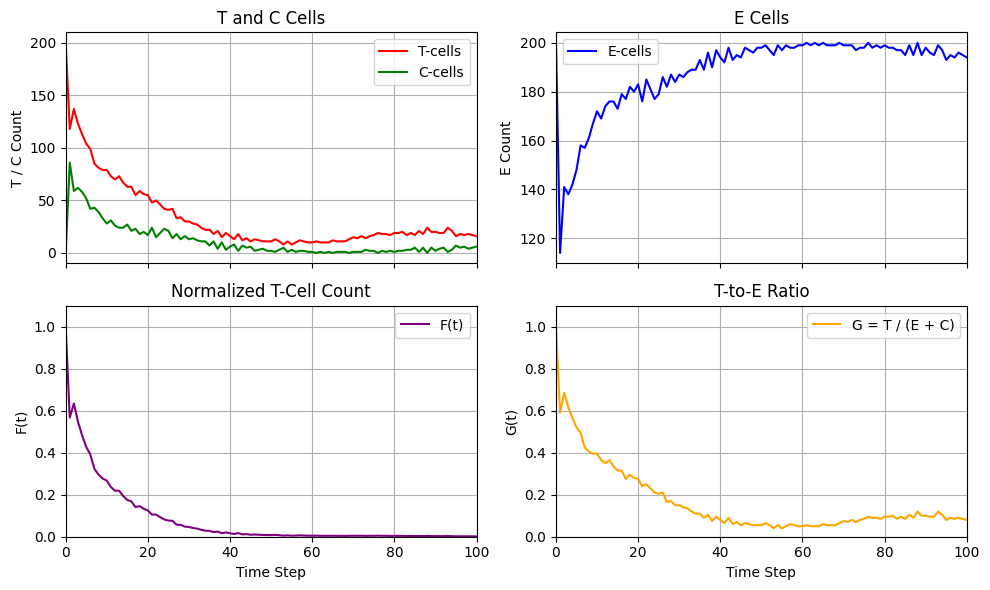

In [ ]:
sim_config: dict = dict(
    E_0=200,
    T_0=200,
    r=0.02,
    m=0.02,
    N=100,
    L=1.0,
    k_on=0.9,
    k_off=0.4,
    k_kill=0.25,
    g_E=0.0,
    g_T=0.04,
    early_stop=(False, 0, 0.0),
    log_all=True,
    use_tqdm=False,
    seed=42,
)
sim = WellSimulation(**sim_config)
sim.run()
sim.plot_snapshot()
sim.plot_history()

Simulating (E>0):   0%|          | 0/100 [00:00<?, ?it/s]

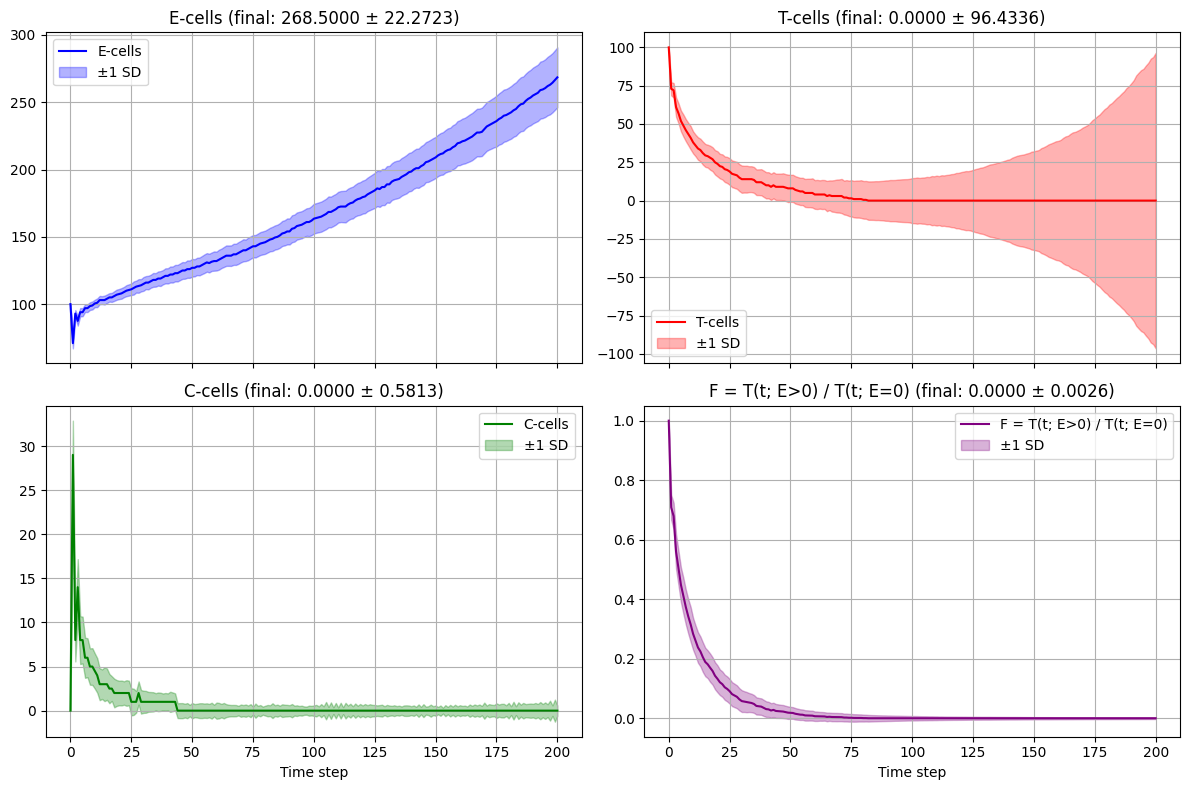

=== Log scale active: replacing E values ≤ 0 with 5.8e+00 ===
=== Log scale active: replacing T values ≤ 0 with 1.0e-01 ===
=== Log scale active: replacing C values ≤ 0 with 1.0e-01 ===
=== Log scale active: replacing F values ≤ 0 with 1.8e-05 ===


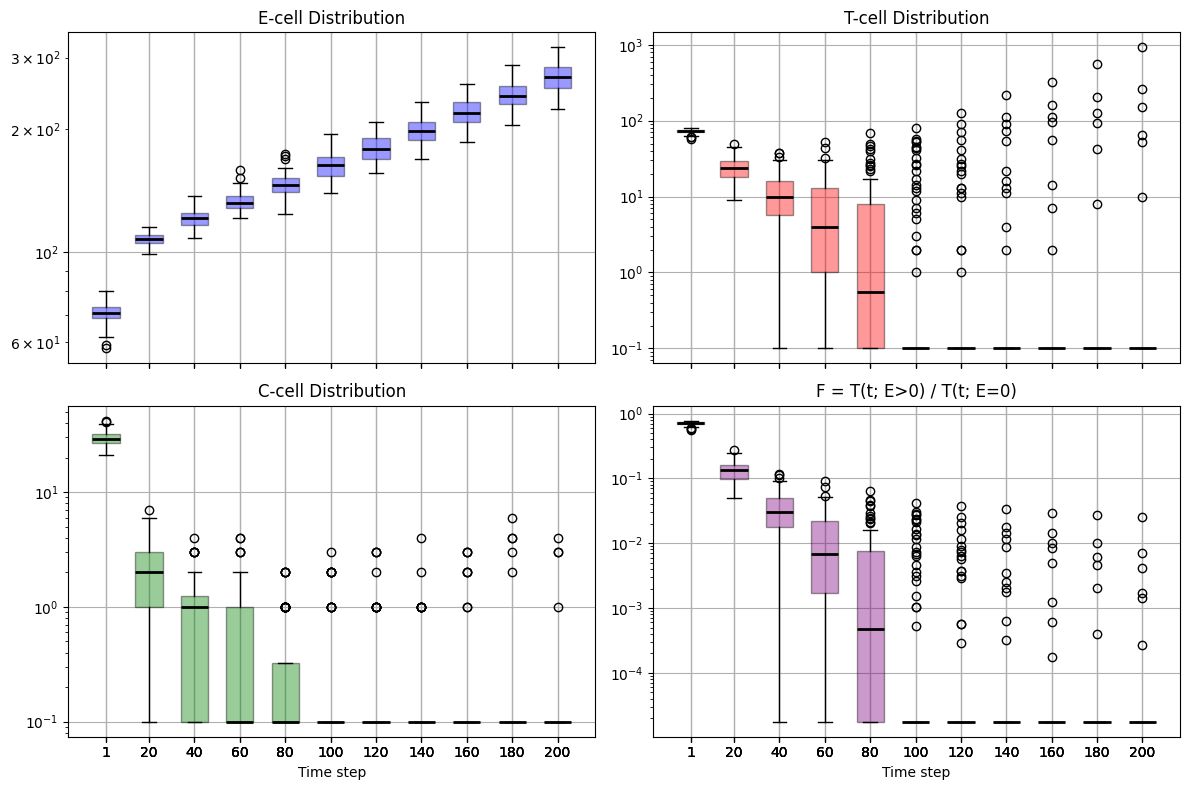

In [4]:
sim_config: dict = dict(
    E_0=100,
    T_0=100,
    r=0.02,
    m=0.02,
    N=200,
    L=1.0,
    k_on=0.9,
    k_off=0.2,
    k_kill=0.8,
    g_E=0.005,
    g_T=0.03,
    early_stop=(False, 0, 0.0),
)
monte_carlo, monte_carlo_baseline = single_scenario_monte_carlo(n_runs=100, sim_kwargs=sim_config)
plot_result_trend(monte_carlo, use_median=True)
plot_result_distribution(monte_carlo, step=20, use_violin=False, use_logscale=True)

In [5]:
E0_range: np.ndarray = np.linspace(1, 202, 40, dtype=int)
T0_range: np.ndarray = np.linspace(1, 202, 40, dtype=int)
base_kwargs: dict = dict(
    r=0.02,
    m=0.02,
    N=200,
    L=1.0,
    k_on=0.9,
    k_off=0.2,
    k_kill=0.8,
    g_E=0.005,
    g_T=0.03,
    early_stop=(False, 0, 0.0),
)

final_F_grid: np.ndarray = grid_scenario_monte_carlo(E0_range, T0_range, base_kwargs, n_runs=10)
plot_F_surface_interactive(final_F_grid, E0_range, T0_range, use_median=True)

Grid Monte Carlo:   0%|          | 0/1600 [00:00<?, ?it/s]

In [6]:
df: pd.DataFrame = pd.read_csv("data.csv")
obs_T: np.ndarray = np.concatenate(([100], np.array(df["T_data"])))
obs_E: np.ndarray = np.concatenate(([100], np.array(df["E_data"])))
obs_C: np.ndarray = np.concatenate(([0], np.array(df["C_data"])))

# Set the fitting parameter.
param_spec: dict = dict(
    E_0=100,
    T_0=100,
    r=0.05,
    m=0.05,
    N=100,
    L=1.0,
    k_on=(0.0, 1.0),
    k_off=0.005,
    k_kill=0.002,
    g_E=0.0,
    g_T=0.01,
    early_stop=(True, max(obs_T / (obs_E + obs_C)) * 10, 0.0),
)

sim_config: dict = fit_params(param_spec, obs_E, obs_T, obs_C, n_runs=30)

Simulating (E>0):   0%|          | 0/100 [00:00<?, ?it/s]

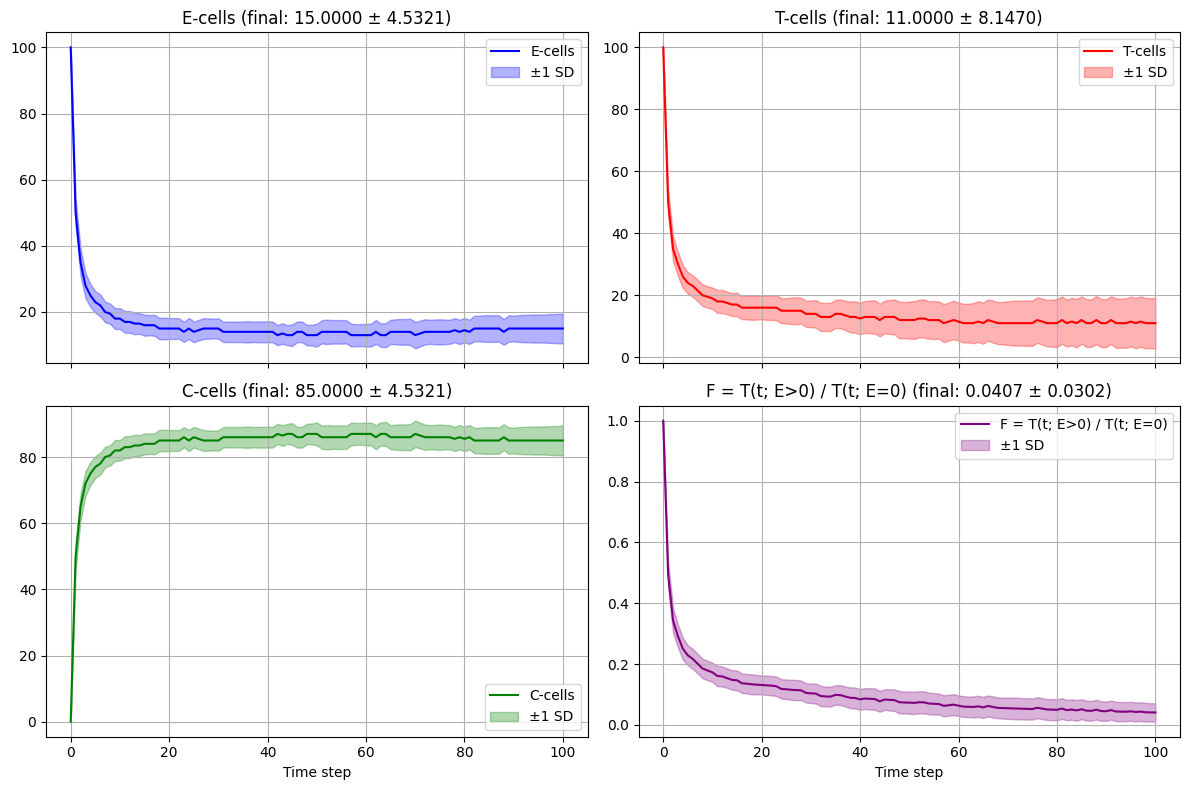

In [7]:
# Fitted Data
monte_carlo, monte_carlo_baseline = single_scenario_monte_carlo(n_runs=100, sim_kwargs=sim_config, seed_offset=9999)
plot_result_trend(monte_carlo, use_median=True)

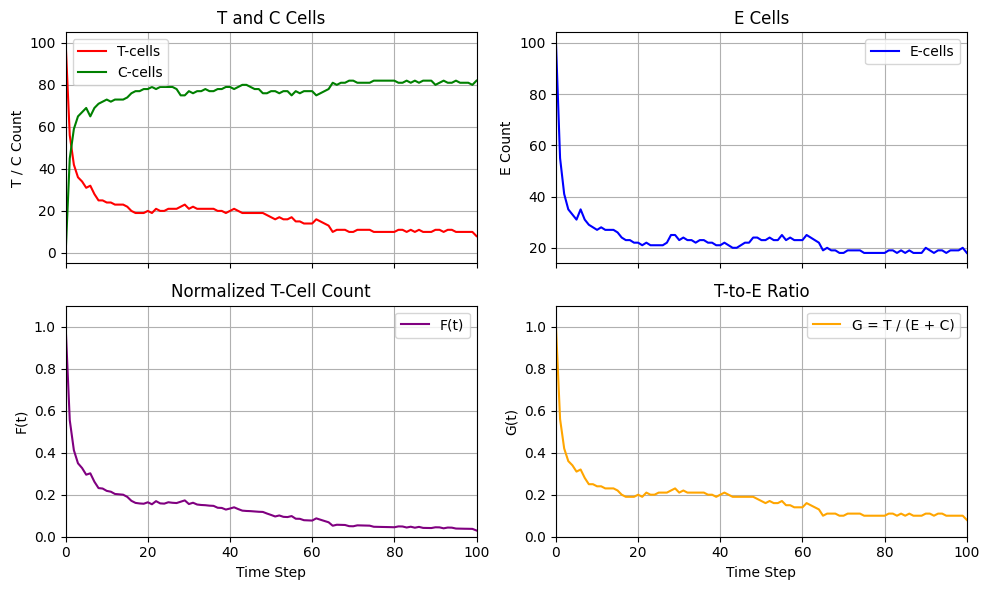

Output()

In [8]:
# One random example
sim = WellSimulation(**sim_config, log_all=True, use_tqdm=False)
sim.run()
sim.plot_history()
sim.plot_snapshot()